# RNNs

In this notebook you will learn how to build Recurrent Neural Networks (RNNs) for time series forecasting and sequence classification.

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/tf2_course/blob/master/06_rnns.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

## Imports

In [1]:
%matplotlib inline

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
from tensorflow import keras
import time

2023-05-14 14:06:29.895994: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
print("python", sys.version)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

python 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:21) 
[GCC 9.4.0]
matplotlib 3.5.3
numpy 1.21.6
pandas 1.3.5
sklearn 1.0.2
tensorflow 2.9.0
keras.api._v2.keras 2.9.0


In [4]:
assert sys.version_info >= (3, 5) # Python ≥3.5 required
assert tf.__version__ >= "2.0"    # TensorFlow ≥2.0 required

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print( len(gpus) )

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1


In [6]:
# mirrored_strategy = tf.distribute.MirroredStrategy()

In [7]:
mnist = keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
sample, sample_label = x_train[0], y_train[0]


In [8]:
print(x_train.shape, y_train.shape, y_train[:10])

(60000, 28, 28) (60000,) [5 0 4 1 9 2 1 3 1 4]


In [9]:
class_names = [str(i) for i in range(10)]
print(class_names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


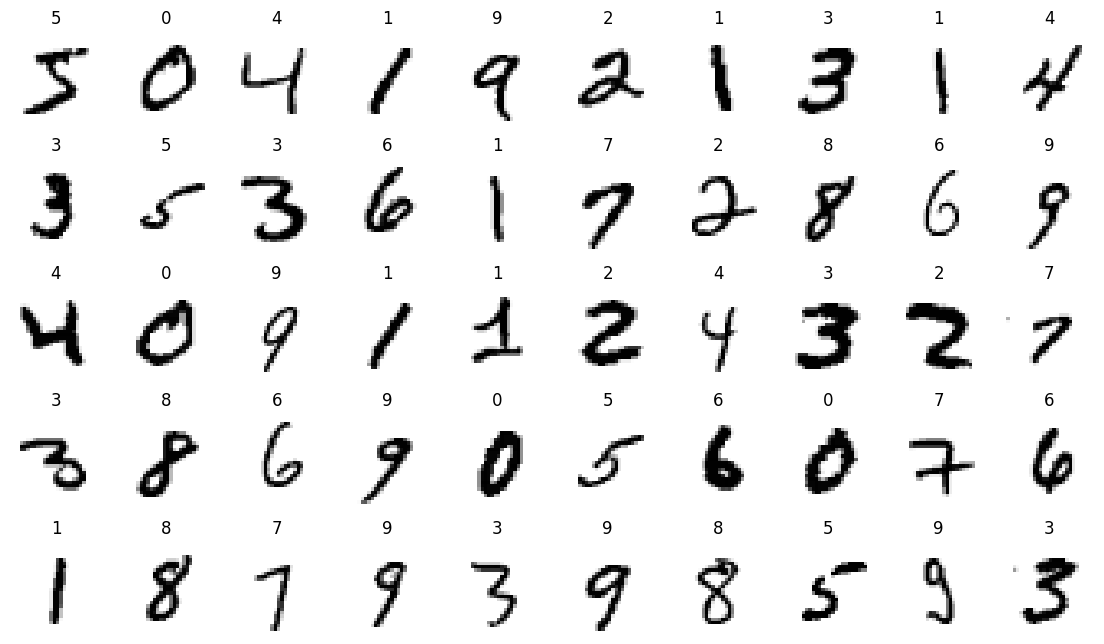

In [10]:
n_rows = 5
n_cols = 10
plt.figure(figsize=(n_cols*1.4, n_rows * 1.6))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(x_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]])
plt.show()

In [11]:
batch_size = 64


In [12]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_data = train_data.batch(batch_size)
val_data = val_data.batch(batch_size)

options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
train_data = train_data.with_options(options)
val_data = val_data.with_options(options)

2023-05-14 14:06:37.052161: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-14 14:06:37.687655: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38251 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0


In [13]:
# Each MNIST image batch is a tensor of shape (batch_size, 28, 28).
# Each input sequence will be of size (28, 28) (height is treated like time).
input_dim = 28

units = 32
output_size = 10  # labels are from 0 to 9

# Build the RNN model
def build_model(allow_cudnn_kernel=True):
    # CuDNN is only available at the layer level, and not at the cell level.
    # This means `LSTM(units)` will use the CuDNN kernel,
    # while RNN(LSTMCell(units)) will run on non-CuDNN kernel.
    if allow_cudnn_kernel:
        # The LSTM layer with default options uses CuDNN.
        lstm_layer = keras.layers.LSTM(units, input_shape=(None, input_dim), return_sequences=True )
        lstm_layer1 = keras.layers.LSTM(units, input_shape=(None, units), return_sequences=True )
        lstm_layer2 = keras.layers.LSTM(units, input_shape=(None, units), return_sequences=True )
        lstm_layer3 = keras.layers.LSTM(units, input_shape=(None, units), return_sequences=True )
        lstm_layer4 = keras.layers.LSTM(units, input_shape=(None, units), return_sequences=True )
        lstm_layer5 = keras.layers.LSTM(units, input_shape=(None, units), return_sequences=True )
        lstm_layer6 = keras.layers.LSTM(units, input_shape=(None, units), return_sequences=True )
        lstm_layer7 = keras.layers.LSTM(units, input_shape=(None, units), return_sequences=True )
        lstm_layer8 = keras.layers.LSTM(units, input_shape=(None, units), return_sequences=True )
        lstm_layer9 = keras.layers.LSTM(units, input_shape=(None, units) )

    else:
        # Wrapping a LSTMCell in a RNN layer will not use CuDNN.
        lstm_layer = keras.layers.RNN(keras.layers.LSTMCell(units), input_shape=(None, input_dim), return_sequences=True)

    # with mirrored_strategy.scope():
    model = keras.models.Sequential(
        [
            lstm_layer,
            # lstm_layer1,
            # lstm_layer2,
            # lstm_layer3,
            # lstm_layer4,
            # lstm_layer5,
            # lstm_layer6,
            # lstm_layer7,
            # lstm_layer8,
            lstm_layer9,
            keras.layers.BatchNormalization(),
            keras.layers.Dense(output_size),
        ]
    )

    model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer="sgd",
        metrics=["accuracy"],
    )

    return model

In [14]:
model = build_model(allow_cudnn_kernel=True)

# model.fit(
#     x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=1
# )

history = model.fit(train_data, validation_data=val_data, epochs=30)

Epoch 1/30


2023-05-14 14:06:42.461680: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


  1/938 [..............................] - ETA: 1:12:48 - loss: 2.8735 - accuracy: 0.0625

2023-05-14 14:06:43.449246: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


938/938 [==============================] - 12s 7ms/step - loss: 1.0414 - accuracy: 0.6761 - val_loss: 0.6820 - val_accuracy: 0.7773
Epoch 2/30
935/938 [============================>.] - ETA: 0s - loss: 0.4389 - accuracy: 0.8724

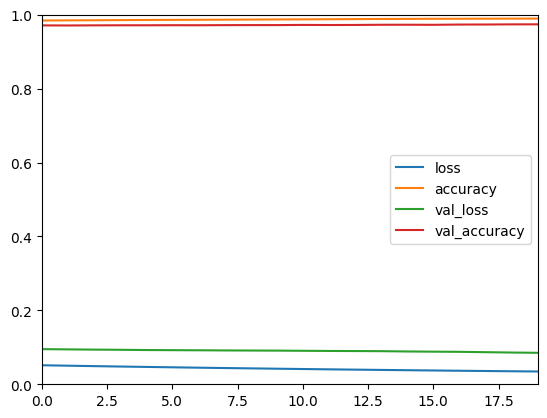

In [ ]:
pd.DataFrame(history.history).plot()
plt.axis([0, 19, 0, 1])
plt.show()

In [ ]:
print(x_train.shape)

(60000, 28, 28)


In [ ]:
# noncudnn_model = build_model(allow_cudnn_kernel=False)
# # noncudnn_model.set_weights(model.get_weights())

# # noncudnn_model.fit(
# #     x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=1
# # )

# noncudnn_model.fit(train_data, validation_data=val_data, epochs=3)